In [1]:
from pathlib import Path
import pandas as pd
from pyro.ops.stats import hpdi, quantile
import torch
import numpy as np
import matplotlib.pyplot as plt

from tapqir.models import Cosmos

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("seed"):
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        truth[data_path.name]["seed"] = int(data_path.name[4:])
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        fit[data_path.name]["seed"] = int(data_path.name[4:])
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        low, high = hpdi(samples, 0.95)
        median = quantile(samples, 0.5)
        fit[data_path.name]["median"] = median.item()
        fit[data_path.name]["low"] = low.item()
        fit[data_path.name]["high"] = high.item()

In [17]:
truth_df = pd.concat(truth.values(), axis=1).T.drop(columns=["offset", "height", "background"])
truth_df = truth_df[["probs_z", "rate_j", "gain", "proximity", "seed"]]
truth_df = truth_df.sort_values(by="seed")
truth_df.style.format("{:.2f}")

,probs_z,rate_j,gain,proximity,seed
seed0,0.15,0.51,17.04,0.36,0.00
seed1,0.14,0.50,3.55,0.38,1.00
seed2,0.18,0.67,19.16,0.32,2.00
seed3,0.09,0.63,5.52,0.23,3.00
seed4,0.01,0.07,5.48,0.36,4.00
seed5,0.10,0.74,12.84,0.57,5.00
seed6,0.16,0.00,16.07,0.47,6.00
seed7,0.02,0.54,7.15,0.35,7.00
seed8,0.37,0.09,5.31,0.30,8.00
seed9,0.07,0.01,9.80,0.40,9.00


In [18]:
print(truth_df.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrr}
\toprule
{} &  probs\_z &  rate\_j &  gain &  proximity &  seed \\
\midrule
seed0  &     0.15 &    0.51 & 17.04 &       0.36 &  0.00 \\
seed1  &     0.14 &    0.50 &  3.55 &       0.38 &  1.00 \\
seed2  &     0.18 &    0.67 & 19.16 &       0.32 &  2.00 \\
seed3  &     0.09 &    0.63 &  5.52 &       0.23 &  3.00 \\
seed4  &     0.01 &    0.07 &  5.48 &       0.36 &  4.00 \\
seed5  &     0.10 &    0.74 & 12.84 &       0.57 &  5.00 \\
seed6  &     0.16 &    0.00 & 16.07 &       0.47 &  6.00 \\
seed7  &     0.02 &    0.54 &  7.15 &       0.35 &  7.00 \\
seed8  &     0.37 &    0.09 &  5.31 &       0.30 &  8.00 \\
seed9  &     0.07 &    0.01 &  9.80 &       0.40 &  9.00 \\
seed10 &     0.05 &    0.81 & 11.86 &       0.53 & 10.00 \\
seed11 &     0.08 &    0.18 &  9.60 &       0.40 & 11.00 \\
seed12 &     0.09 &    0.01 & 10.02 &       0.35 & 12.00 \\
seed13 &     0.10 &    0.19 &  5.92 &       0.29 & 13.00 \\
seed14 &     0.10 &    0.27 &  3.03 &       0.30 & 14.00 \\


In [19]:
fit_df = pd.concat(fit.values(), axis=1).T.drop(columns=[
    "probs_z_0", "width_mean_0", "width_size_0", "height_scale",
    "FN", "TP", "TN", "FP",
    "height", "median", "low", "high"
])
fit_df = fit_df[["-ELBO", "probs_z_1", "rate_j", "gain", "proximity_0", "MCC", "Recall", "Precision", "seed"]]
fit_df = fit_df.sort_values(by="seed")
fit_df.style.format("{:.2f}")

,-ELBO,probs_z_1,rate_j,gain,proximity_0,MCC,Recall,Precision,seed
seed0,5246925.00,0.15,0.50,17.68,0.39,0.00,1.00,0.15,0.00
seed1,4515645.50,0.14,0.50,3.58,0.38,0.00,1.00,0.14,1.00
seed2,5310342.50,0.17,0.64,19.35,0.34,0.00,1.00,0.19,2.00
seed3,4734302.00,0.09,0.63,5.57,0.22,0.00,1.00,0.10,3.00
seed4,4675881.50,0.01,0.06,5.50,0.35,0.00,1.00,0.01,4.00
seed5,5132568.50,0.10,0.73,12.93,0.58,0.00,1.00,0.11,5.00
seed6,5179174.00,0.17,0.00,16.13,0.47,0.00,1.00,0.17,6.00
seed7,4844428.50,0.02,0.54,7.18,0.35,0.00,1.00,0.02,7.00
seed8,4678007.00,0.37,0.09,5.33,0.30,0.00,1.00,0.37,8.00
seed9,4947713.50,0.09,0.01,9.82,0.40,0.00,1.00,0.08,9.00


In [20]:
print(fit_df.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &      -ELBO &  probs\_z\_1 &  rate\_j &  gain &  proximity\_0 &  MCC &  Recall &  Precision &  seed \\
\midrule
seed0  & 5246925.00 &       0.15 &    0.50 & 17.68 &         0.39 & 0.00 &    1.00 &       0.15 &  0.00 \\
seed1  & 4515645.50 &       0.14 &    0.50 &  3.58 &         0.38 & 0.00 &    1.00 &       0.14 &  1.00 \\
seed2  & 5310342.50 &       0.17 &    0.64 & 19.35 &         0.34 & 0.00 &    1.00 &       0.19 &  2.00 \\
seed3  & 4734302.00 &       0.09 &    0.63 &  5.57 &         0.22 & 0.00 &    1.00 &       0.10 &  3.00 \\
seed4  & 4675881.50 &       0.01 &    0.06 &  5.50 &         0.35 & 0.00 &    1.00 &       0.01 &  4.00 \\
seed5  & 5132568.50 &       0.10 &    0.73 & 12.93 &         0.58 & 0.00 &    1.00 &       0.11 &  5.00 \\
seed6  & 5179174.00 &       0.17 &    0.00 & 16.13 &         0.47 & 0.00 &    1.00 &       0.17 &  6.00 \\
seed7  & 4844428.50 &       0.02 &    0.54 &  7.18 &         0.35 & 0.00 &    1.00 &       0.02 & 

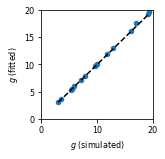

In [34]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["gain"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["gain"], fit_df["gain"], s=20)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("$g$ (simulated)", fontsize=8)
plt.ylabel("$g$ (fitted)", fontsize=8)
plt.savefig("/tmp/gain.svg")
plt.show()

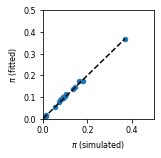

In [32]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["probs_z"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["probs_z"], fit_df["probs_z_1"], s=20)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\pi$ (simulated)", fontsize=8)
plt.ylabel(r"$\pi$ (fitted)", fontsize=8)
plt.savefig("/tmp/probsz.svg")
plt.show()

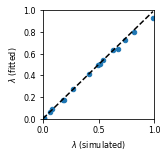

In [33]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.xlim(0, 1.)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\lambda$ (simulated)", fontsize=8)
plt.ylabel(r"$\lambda$ (fitted)", fontsize=8)
plt.savefig("/tmp/ratej.svg")
plt.show()

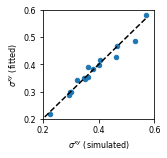

In [31]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["proximity"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["proximity"], fit_df["proximity_0"], s=20)
plt.xlim(0.2, 0.6)
plt.ylim(0.2, 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"$\sigma^{xy}$ (simulated)", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.savefig("/tmp/proximity.svg")
plt.show()

In [4]:
from tapqir.distributions import AffineBeta

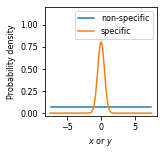

In [14]:
plt.figure(figsize=(2, 2))
x = torch.arange(-7.5, 7.5, 0.1)
d1 = AffineBeta(0, 2, -7.5, 7.5)
d2 = AffineBeta(0, 230, -7.5, 7.5)
plt.plot(x, d1.log_prob(x).exp(), label="non-specific")
plt.plot(x, d2.log_prob(x).exp(), label="specific")
plt.xlabel(r"$x$ or $y$", fontsize=8)
plt.ylabel("Probability density", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(-0.03, 1.2)
plt.legend(fontsize=8)
plt.savefig("/tmp/prior.svg")
plt.show()